In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

from simulate import SimulateData
import numba_functions
from hmm import HMM
from sklearn.metrics.cluster import adjusted_rand_score as ari

In [2]:
import pickle

# Load state sequence and data from the pickle file
with open('hmm_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Access the loaded data
loaded_ss = loaded_data['state_sequence']
loaded_data = loaded_data['data']
import plot_hmm

In [6]:
from importlib import reload
import numba_functions
reload(numba_functions)
import mv_bayesian_hmm
reload(mv_bayesian_hmm)

<module 'mv_bayesian_hmm' from '/Users/david/Documents/mastersCode/ubm/tuts/bhmm/mv_bayesian_hmm.py'>

init ari 0.496


/Users/david/Documents/mastersCode/ubm/tuts/bhmm/plot_hmm.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse(mu, w, h, theta, color=color, edgecolor='black')  # edgecolor for better visibility


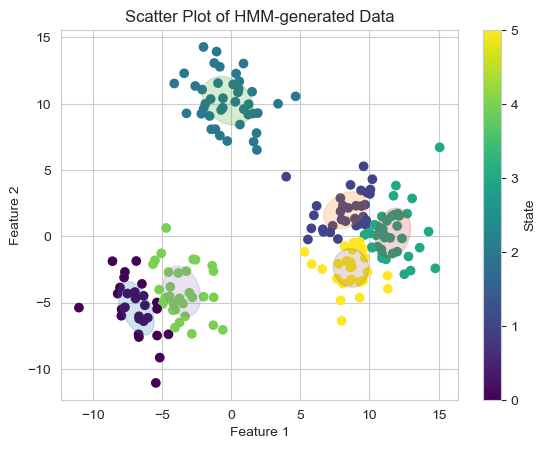

In [7]:
new_hmm = mv_bayesian_hmm.BayesianHMM(loaded_data, loaded_ss, 6, iterations=50)

In [8]:
new_hmm.fit()

starting gibbs sampling
completed gibbs sampling


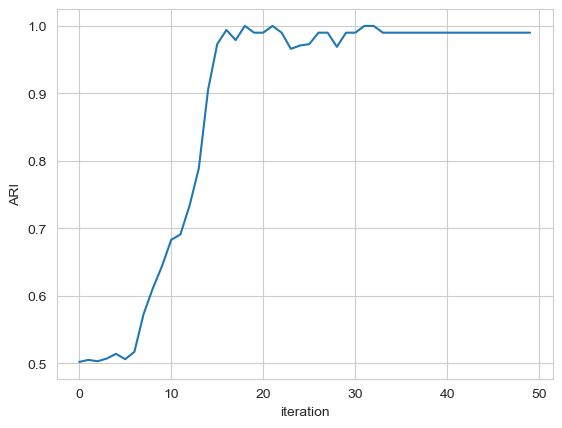

In [9]:
plt.plot(range(0,len(new_hmm.ARI)), new_hmm.ARI, marker="None")
plt.xlabel('iteration')
plt.ylabel('ARI')
#plt.savefig("./image/ari.png")
plt.show()
plt.close()

/Users/david/Documents/mastersCode/ubm/tuts/bhmm/plot_hmm.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse(mu, w, h, theta, color=color, edgecolor='black')  # edgecolor for better visibility


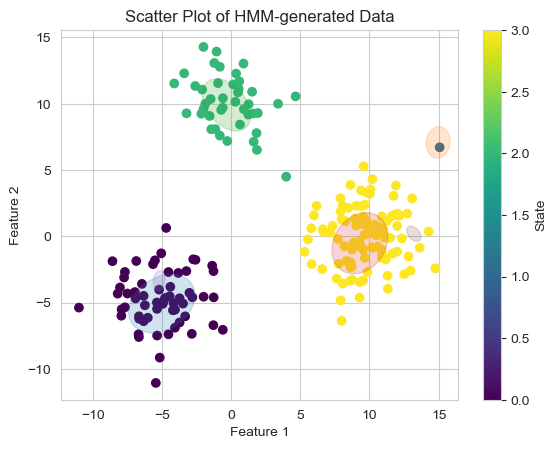

In [11]:
import plot_hmm
plot_hmm.plot_hmm_data(loaded_data, new_hmm.Z, new_hmm.K, new_hmm.mu, new_hmm.sigma)